In [1]:
!pip install torchensemble

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os, os.path
import numpy as np
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms

from torchensemble import VotingClassifier
from torchensemble.utils.logging import set_logger

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [3]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [6]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                            transforms.RandomRotation(degrees=(-10, 10)),
                                            transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                            transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                            contrast=(1, 1.5),
                                                                                            saturation=(1, 1.5),
                                                                                            hue=(0, 0.5))]),
                                            transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                      inplace=False),
                                            transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # WeightedRandomSampler for train loader
    idx2class = {v: k for k, v in train_data.class_to_idx.items()}

    target_list = torch.tensor(train_data.targets)
    class_count = [i for i in get_class_distribution(train_data, idx2class).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights_all = class_weights[target_list]
    weighted_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, sampler=weighted_sampler, drop_last=True)
    
    # WeightedRandomSampler for test loader
    idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

    target_list_test = torch.tensor(test_data.targets)
    class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
    class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
    class_weights_all_test = class_weights_test[target_list_test]
    weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, sampler=weighted_sampler_test)

    return train_loader, test_loader, classes

In [7]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/'

hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Y5 6
I9 116
O34 15
V13 63
U7 3
D46 40
E34 97
G1 28
V31 106
S34 8
D36 47
Q1 13
V30 6
F35 2
O4 11
M23 30
S29 212
R8 53
W11 4
X1 185
Y1 1
D21 146
D2 19
E23 8
X8 4
Z1 39
D4 29
V28 28
I10 32
O1 16
M17 291
F31 6
G43 157
D58 28
O49 10
G17 156
R4 2
Q3 61
W24 31
N35 358


<BarContainer object of 40 artists>

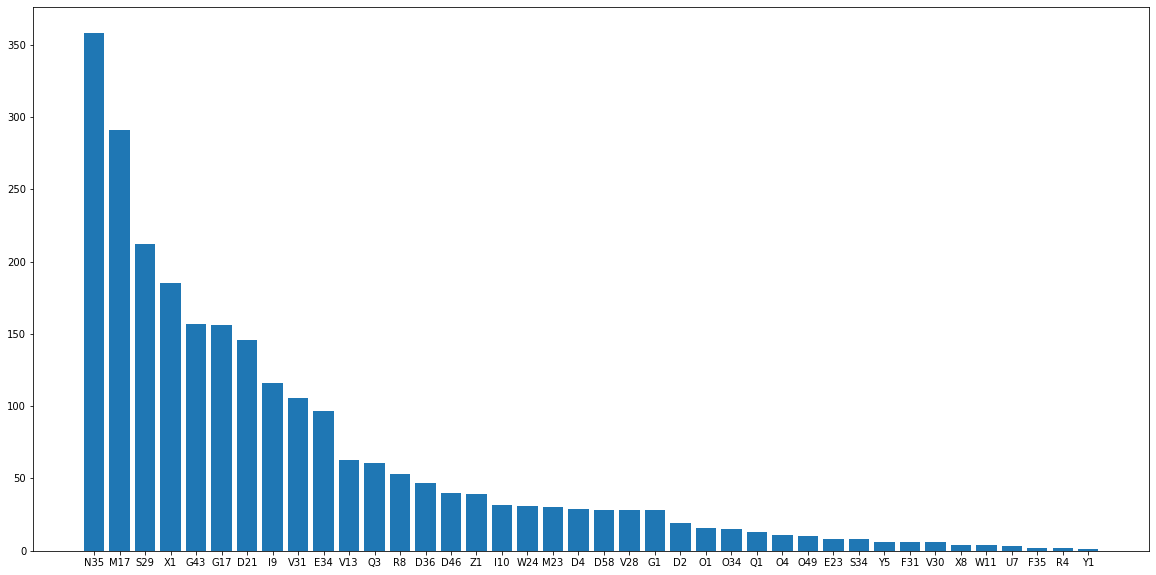

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [9]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

In [10]:
# Whether to extract features with the model
feature_extract = False

model_selection = "resnet-50"

# False if you want scratch model, True if you want pretrained model
whether_to_pretrain = False

# Load the model
if model_selection == "resnet-50":
    resnet50 = models.resnet50(pretrained=whether_to_pretrain)

# Number of features in the last layer of resnet
n_inputs = resnet50.fc.in_features

# Add last linear layer (n_inputs -> 40 hieroglyph classes)
# New layers automatically have requires_grad = True
last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet50.cuda()

In [11]:
epochs = 30

# Define the ensemble
ensemble = VotingClassifier(
    estimator=resnet50,               # here is your deep learning model
    n_estimators=3,                        # number of base estimators
    cuda=True
)

# Set the optimizer
ensemble.set_optimizer(
    "Adam",                                 # type of parameter optimizer
    lr=1e-3,                       # learning rate of parameter optimizer
    weight_decay=5e-4,              # weight decay of parameter optimizer
)

# Set the learning rate scheduler
ensemble.set_scheduler(
    "CosineAnnealingLR",                    # type of learning rate scheduler
    T_max=epochs,                           # additional arguments on the scheduler
)

# Train the ensemble
ensemble.fit(
    train_loader,
    epochs=epochs,                          # number of training epochs
)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 4.19425 | Correct: 0/20
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 3.72008 | Correct: 1/20
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 4.03164 | Correct: 1/20
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 3.32599 | Correct: 3/20
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 4.06092 | Correct: 1/20
Estimator: 002 | Epoch: 000 | Batch: 100 | Loss: 4.11065 | Correct: 0/20
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 2.95241 | Correct: 3/20
Estimator: 000 | Epoch: 001 | Batch: 100 | Loss: 1.84059 | Correct: 9/20
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 3.24114 | Correct: 0/20
Estimator: 001 | Epoch: 001 | Batch: 100 | Loss: 2.97599 | Correct: 7/20
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 3.94600 | Correct: 1/20
Estimator: 002 | Epoch: 001 | Batch: 100 | Loss: 2.97977 | Correct: 2/20
Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 2.14221 | Correct: 8/20
Estimator: 000 | Epoch: 002 | Batch: 100 | Loss: 1.

In [12]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
test_loss, class_correct, class_total, labels, predictions = test_model(classes, ensemble, test_loader, criterion)

Test Loss: 2.803503



In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [16]:
# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Accuracy of    D2: 100% (20/20)
Test Accuracy of   D21: 94% (16/17)
Test Accuracy of   D36: 100% (14/14)
Test Accuracy of    D4: 93% (15/16)
Test Accuracy of   D46: 90% (18/20)
Test Accuracy of   D58: 100% (18/18)
Test Accuracy of   E23: 86% (13/15)
Test Accuracy of   E34: 100% (17/17)
Test Accuracy of   F31: 100% (19/19)
Test Accuracy of   F35: 100% (25/25)
Test Accuracy of    G1: 93% (14/15)
Test Accuracy of   G17: 93% (15/16)
Test Accuracy of   G43: 100% ( 9/ 9)
Test Accuracy of   I10: 100% (15/15)
Test Accuracy of    I9: 100% (14/14)
Test Accuracy of   M17: 88% (15/17)
Test Accuracy of   M23: 100% (13/13)
Test Accuracy of   N35: 100% (18/18)
Test Accuracy of    O1: 100% (13/13)
Test Accuracy of   O34: 100% (18/18)
Test Accuracy of    O4: 93% (14/15)
Test Accuracy of   O49: 100% (13/13)
Test Accuracy of    Q1: 85% (12/14)
Test Accuracy of    Q3: 100% (11/11)
Test Accuracy of    R4: 100% (18/18)
Test Accuracy of    R8: 94% (16/17)
Test Accuracy of   S29: 100% (19/19)
Test Accura